In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import glob 
import matplotlib.pyplot as plt
import matplotlib as mpl

sns.set_context("talk")
data_dir = "/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/homfam/"

# load families summary
summary_homfam_exthomfam = pd.read_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/01_summary_homfam_exthomfam.csv")
summary_homfam = summary_homfam_exthomfam[summary_homfam_exthomfam.dataset == "homfam"]
families = summary_homfam.drop(["subset", "file", "min_length", "max_length", "perc_ref_total", "dataset"], axis = 1)

# 1. PREP SCORES
def get_scores(score_files): 
    def parse_score(score_file): 
        return(pd.read_csv(score_file,sep = ";", header = None).drop(4, axis = 1))

    scores = pd.concat(list(map(parse_score, score_files)))
    scores = scores.iloc[:,0:4]
    scores.columns = ['name', 'sp', 'tc', 'column']
    #scores.name = scores.name.str.split(".", expand = True)[:-1]
    #scores[["family", "method", "bucket_size", "align_method", "tree_method"]] = scores.name.str.split(".", expand = True)
    #scores = scores.drop("method", axis = 1)
    return(scores)


def plot_scatter_perc(df1,df2,xlabel,ylabel,
                      palette = sns.dark_palette("#3399FF", reverse = True, as_cmap=True),
                      log = True, 
                      title = "regressive on homfam", hue_var = "sim", metric = "sp", size_fig = 1): 
    f, ax = plt.subplots(figsize=(8*size_fig,6.4*size_fig ))
    
    # Prep df 
    df = df1.merge(df2, on = ["family", hue_var])
    
    
    hue = df[hue_var]
    # colorbar 
    norm = mpl.colors.Normalize( vmin=0, vmax=100)
    sm = plt.cm.ScalarMappable(cmap=palette, norm=norm)
    sm.set_array([])
    
# Color bar 
    cbar =ax.figure.colorbar(sm, ticks=[0,50,100], format=mpl.ticker.ScalarFormatter())
    cbar.ax.set_yticklabels(["0", "50", "100"]) 
    cbar.ax.set_ylabel('avg % similarity', rotation=270, labelpad = 20, fontsize = "small")
    
    metric_x = metric+"_x"
    metric_y = metric+"_y"
    # Plot 
    ax = sns.scatterplot(data = df, x = metric_x,
                    y = metric_y,
                    hue = hue_var,
                    s = 100,
                    palette = palette)

    # % above the line
    perc_y_better_than_x = (len(list(filter(lambda ele: ele == True, list(df[metric_x] <= df[metric_y])))) / len(list(df[metric_x]  >= df[metric_y] ))) * 100
    
    # Diagonal line
    ax.axline((1, 1), slope=1, ls="--", c=".2", lw = 0.8)
    
    ax.set(xlim = (0,100), ylim = (0,100))
    ax.get_legend().remove()
    
    # Axis labels
    ax.set(xlabel=xlabel,
           ylabel=ylabel,
           title = title + "\n metric: "+metric+"\n (n = "+str(len(df[metric_x] ))+") \n\n % y >= x  "+str(round(perc_y_better_than_x,1))+" \n")

In [6]:
families[families.family == "Acetyltransf"]

,family,n_sequences,mean_length,size_group
3,Acetyltransf,46285,82.989716,xlarge


In [7]:
scores = pd.read_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/scores_ref_foldseek_libraries.csv")

In [8]:
def get_summary_lib(library):
    file1 = open(library, 'r')
    Lines = file1.readlines()


    count = 0
    header_finished = False

    seq_indexes = pd.DataFrame()
    residues = pd.DataFrame()

    # Strips the newline character
    for line in Lines:
        if line.startswith("!"):
            count += 1
            continue
        if count == 0:
            count += 1
            continue
        elif count == 1: 
            nseq = int(line)
            count += 1
            continue
        elif count == nseq+2: 
            header_finished = True

        if not header_finished: 
            count += 1
            # ----- PARSE INDEXES SEQUENCES 
            seq_id = line.split()[0]
            seq = line.split()[2]
            idx_seq = count-2
            entry = pd.DataFrame({"index":[idx_seq], "seq_name":[seq_id]})
            seq_indexes = pd.concat([seq_indexes, entry])
        else:
            # ------- PARSE RESIDUES 
            if line.startswith("#"): 
                seq1 = line.replace("#","").split(" ")[0]
                seq2 = line.replace("#","").split(" ")[1]
            else:
                res1 = line.split()[0]
                res2 = line.split()[1]
                value = line.split()[2]
                res_entry = pd.DataFrame({"seq1":[seq1], "seq2":[seq2], "res1":[res1], "res2":[res2], "value":[value]})
                residues = pd.concat([residues,res_entry])
    residues["id"] = residues.seq1+"-"+residues.seq2+"-"+residues.res1+"-"+residues.res2
    return(residues)

In [95]:
fam = "blmb"

library_seq = "/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/homfam/libraries/sequence/"+fam+"-ref/"+fam+"-ref_sequence.library"
library_fs = "/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/homfam/libraries/foldseek/AF2_PRED/"+fam+"-ref/"+fam+"-ref.library"
library_tmalign = "/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/homfam/libraries/TMalign_pair/AF2_PRED/"+fam+"-ref/"+fam+"ref_TMalign_pair.library"
library_sap = "/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/homfam/libraries/sap_pair/AF2_PRED/"+fam+"-ref/"+fam+"-ref_sap_pair.library"
library_seq_fs = "/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/homfam/libraries/foldseek_sequence/AF2_PRED/"+fam+"-ref/"+fam+"-ref_merged.library"
library_tmalign_seq = "/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/homfam/libraries/tmalign_sequence/AF2_PRED/"+fam+"-ref/"+fam+"-ref_merged.library"


In [96]:
# Sequence 
residues_seq = get_summary_lib(library_seq)
residues_seq["library"] = "sequence"

In [97]:
# both seq and str 
residues_seq_fs = get_summary_lib(library_seq_fs)
residues_seq_fs["library"] = "sequence_foldseek"

In [98]:
# Structure fs
residues_foldseek = get_summary_lib(library_fs)
residues_foldseek["library"] = "foldseek"

In [86]:
# Structure tmalign
# residues_tmalign = get_summary_lib(library_tmalign)
# residues_tmalign["library"] = "tmalign"

In [99]:
# Structure tmalign
residues_tmalign_seq = get_summary_lib(library_tmalign_seq)
residues_tmalign_seq["library"] = "tmalign_seq"

In [100]:
# Structure tmalign
residues_sap = get_summary_lib(library_sap)
residues_sap["library"] = "sap"

<AxesSubplot:xlabel='value_seq', ylabel='value_foldseek'>

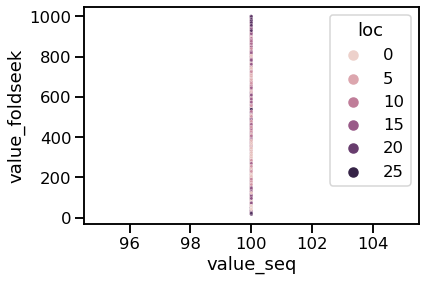

In [101]:
df = pd.merge(residues_sap,residues_seq, on = "id", suffixes = ("_seq", "_foldseek"))
df["value_seq"] = (df.value_seq).astype(int)
df["value_foldseek"] = (df.value_foldseek).astype(int)
df["loc"] = pd.to_numeric(df["res1_seq"])/10
df["loc"] = df["loc"].astype(int)
#df["value_seq"] = (df.value_seq/100).astype(int)
#df["value_foldseek"] = (df.value_foldseek/100).astype(int)
sns.scatterplot(data = df, x = "value_seq", y = "value_foldseek", s = 10, hue = "loc")

In [102]:
df

,seq1_seq,seq2_seq,res1_seq,res2_seq,value_seq,id,library_seq,seq1_foldseek,seq2_foldseek,res1_foldseek,res2_foldseek,value_foldseek,library_foldseek,loc
0,1,2\n,5,7,100,1-2\n-5-7,sap,1,2\n,5,7,51,sequence,0
1,1,2\n,6,8,100,1-2\n-6-8,sap,1,2\n,6,8,60,sequence,0
2,1,2\n,7,9,100,1-2\n-7-9,sap,1,2\n,7,9,66,sequence,0
3,1,2\n,8,10,100,1-2\n-8-10,sap,1,2\n,8,10,75,sequence,0
4,1,2\n,9,11,100,1-2\n-9-11,sap,1,2\n,9,11,101,sequence,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2224,5,6\n,215,210,100,5-6\n-215-210,sap,5,6\n,215,210,985,sequence,21
2225,5,6\n,216,211,100,5-6\n-216-211,sap,5,6\n,216,211,978,sequence,21
2226,5,6\n,217,212,100,5-6\n-217-212,sap,5,6\n,217,212,969,sequence,21
2227,5,6\n,218,213,100,5-6\n-218-213,sap,5,6\n,218,213,955,sequence,21


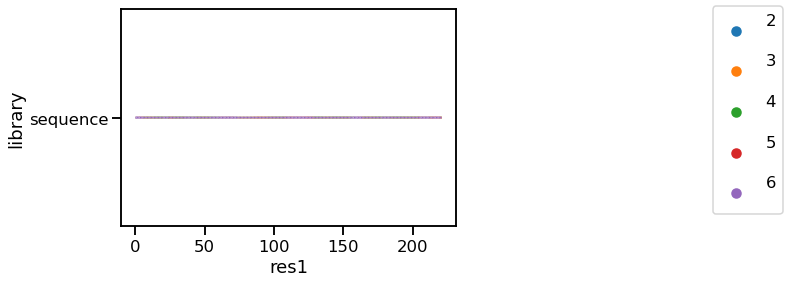

In [103]:
sequence = "1"

residues= residues_seq

df = residues[(residues.seq1 == sequence)]
df.value = df.value.astype(int)
df.res1 = df.res1.astype(int)

ax = sns.scatterplot(data = df, x = "res1", y = "library", s = 3, hue = "seq2") 
ax.legend(bbox_to_anchor=(2, 1.05))


In [104]:
df

,seq1,seq2,res1,res2,value,id,library
0,1,2\n,1,1,107,1-2\n-1-1,sequence
0,1,2\n,1,2,163,1-2\n-1-2,sequence
0,1,2\n,1,4,29,1-2\n-1-4,sequence
0,1,2\n,1,6,599,1-2\n-1-6,sequence
0,1,2\n,2,2,38,1-2\n-2-2,sequence
...,...,...,...,...,...,...,...
0,1,6\n,218,212,46,1-6\n-218-212,sequence
0,1,6\n,218,213,14,1-6\n-218-213,sequence
0,1,6\n,219,213,74,1-6\n-219-213,sequence
0,1,6\n,219,214,18,1-6\n-219-214,sequence


[Text(0.5, 0, 'residue of seq1')]

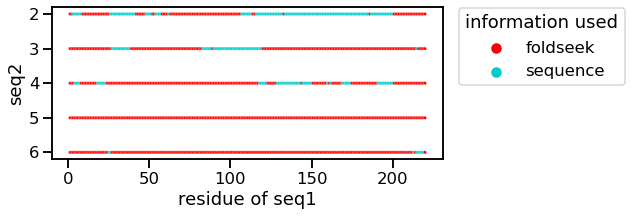

In [114]:
import warnings
warnings.filterwarnings('ignore')

size_fig = 0.7
f, ax = plt.subplots(figsize=(10*size_fig,4*size_fig ))

seq1 = "1"
#seq2 = "6"

#seqs  = ["1","2", "3", "4", "5", "6"]
seqs  = ["2"]

#residues= residues_foldseek
#residues= pd.concat([residues_tmalign, residues_tmalign_seq,residues_seq ])
residues= pd.concat([residues_foldseek,residues_seq ])

residues.seq2 = residues.seq2.replace(r'\n','', regex=True).str.strip() 

#df = residues[(residues.seq1 == sequence) & (residues.seq2.isin(seqs))]
df = residues[(residues.seq1 == seq1)]

df.value = df.value.astype(int)
df.res1 = df.res1.astype(int)
df.res2 = df.res2.astype(int)
#df = df[df.res1 < 50 ]
df.value = df.value.astype(int)
df.value = df.value/10
df.value = df.value.astype(int).astype(float)
df["s"] = 150
df.loc[df.library=="foldseek", 's'] = 150
df.loc[df.library=="sequence", 's'] = 50

df = df.reset_index()
df['value_transformed'] = df.groupby("id")['value'].transform('max')

# group the data by 'group' and find the index of the max value for each group
idx = df.groupby(['res1', "seq2"])['value_transformed'].idxmax()
# use the index to select the columns with the max values for each group
df = df.loc[idx,:]

s = df.s
ax = sns.scatterplot(data = df, x = "res1", y = "seq2", s = 10, hue = "library", palette = ["red", "#00CCCC"]) 
ax.legend(bbox_to_anchor=(1.02, 1.05), title = "information used")
ax.set(xlabel = "residue of seq1")


,index,seq1,seq2,res1,res2,value,id,library,s,value_transformed
0,0,1,2,1,1,68.0,1-2\n-1-1,foldseek,150,68.0
7,0,1,2,2,2,63.0,1-2\n-2-2,foldseek,150,63.0
3263,0,1,2,3,8,64.0,1-2\n-3-8,sequence,50,64.0
3266,0,1,2,4,9,64.0,1-2\n-4-9,sequence,50,64.0
3270,0,1,2,5,10,64.0,1-2\n-5-10,sequence,50,64.0
...,...,...,...,...,...,...,...,...,...,...
850,0,1,2,216,254,6.0,1-2\n-216-254,foldseek,150,43.0
858,0,1,2,217,255,8.0,1-2\n-217-255,foldseek,150,51.0
865,0,1,2,218,256,8.0,1-2\n-218-256,foldseek,150,52.0
872,0,1,2,219,257,7.0,1-2\n-219-257,foldseek,150,54.0


In [ ]:
# What could be interesting, regions where structure is better, regions where sequence is better 

In [116]:
# FILE FOR PYMOL 
df = df[df.seq2 == "6"]
result = df[["res1", "library"]]
#result["res1"] = result["res2"]
result = result[["res1", "library"]]
result.to_csv("/home/luisasantus/Desktop/test.blmb.csv", index = False)